In [47]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP
from utils.features.tsne import tsne

In [48]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Load the raw Fashion-MNIST data.
train_data, test_data = fashion_mnist.load_data()

X_train_raw, y_train = train_data
X_test_raw, y_test = test_data

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 784) (1000, 784) (10000, 784) (100, 784)
Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## TSNE of original data

In [50]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test_raw[random_select,:,:].reshape(500,X_train.shape[1]).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

2.9269147474058252
The 100 th loop cost: 11.725189319261311, computation time: 0.9363274574279785
The 200 th loop cost: 0.5246577462452497, computation time: 1.8854167461395264
The 300 th loop cost: 0.4947080366060505, computation time: 2.8322997093200684
The 400 th loop cost: 0.48999486640385254, computation time: 3.7663092613220215
The 500 th loop cost: 0.48903157826174104, computation time: 4.684612035751343
The 600 th loop cost: 0.48870669869310657, computation time: 5.601235866546631
The 700 th loop cost: 0.4885740090644256, computation time: 6.533647060394287
The 800 th loop cost: 0.48851350762928947, computation time: 7.4613258838653564
The 900 th loop cost: 0.4884837338916007, computation time: 8.386306524276733
The 1000 th loop cost: 0.4884684949935152, computation time: 9.320033311843872
it takes 9.616616249084473 seconds


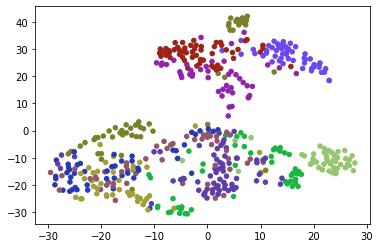

In [51]:
## visualize tSNE of original data
labels = y_test[random_select]   
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

# labels.shape (500,)
# 从 y_test 里随机选了500个数
# labels[0:10] = array([9, 0, 8, 7, 7, 2, 5, 0, 9, 3], dtype=uint8)

# colors 的 random.rand 函数生成一个 uniform 分布，形状是 （20，3）

# labels 是 （500，） 一维array， to_list 生成 500 长的 list

#  

In [52]:
color_labels[:5]

[array([0.14803009, 0.22493182, 0.70283122]),
 array([0.3666209 , 0.23830282, 0.66489198]),
 array([0.56770046, 0.33326969, 0.40686535]),
 array([0.3666209 , 0.23830282, 0.66489198]),
 array([0.58317008, 0.7721867 , 0.42711067])]

## A simple keras sequential model

In [54]:
import keras

model_keras = tf.keras.Sequential()
model_keras.add(tf.keras.layers.Input(shape = (784,)))
model_keras.add(tf.keras.layers.Dense(100,"relu"))
model_keras.add(tf.keras.layers.Dense(20))

model_keras.compile(
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              optimizer=tf.keras.optimizers.SGD(0.001),
              metrics=['accuracy']) 

model_keras.fit(X_train, tf.one_hot(y_train,20),validation_data = (X_val, tf.one_hot(y_val,20)), batch_size=200, epochs=10) 

Epoch 1/10
245/245 [==============================] - 1s 2ms/step - loss: 10.5049 - accuracy: 0.7624 - val_loss: 5.3119 - val_accuracy: 0.7980
Epoch 2/10
245/245 [==============================] - 0s 1ms/step - loss: 4.1150 - accuracy: 0.8191 - val_loss: 3.4326 - val_accuracy: 0.8230
Epoch 3/10
245/245 [==============================] - 0s 1ms/step - loss: 2.6628 - accuracy: 0.8320 - val_loss: 2.9830 - val_accuracy: 0.8000
Epoch 4/10
245/245 [==============================] - 0s 1ms/step - loss: 1.9847 - accuracy: 0.8416 - val_loss: 2.6902 - val_accuracy: 0.8050
Epoch 5/10
245/245 [==============================] - 0s 1ms/step - loss: 1.5725 - accuracy: 0.8475 - val_loss: 2.2679 - val_accuracy: 0.8010
Epoch 6/10
245/245 [==============================] - 0s 1ms/step - loss: 1.2906 - accuracy: 0.8537 - val_loss: 2.0281 - val_accuracy: 0.8100
Epoch 7/10
245/245 [==============================] - 0s 1ms/step - loss: 1.1105 - accuracy: 0.8561 - val_loss: 2.0093 - val_accuracy: 0.7860
Epoch

In [ ]:
h = X_test[random_select]

h = model_keras(X)  # h.shape  (500,20)
# print(h[0])
h = tf.keras.activations.softmax(h, axis=1)
# print(h[0])
# np.sum(tf.keras.activations.softmax(Y, axis=1),axis=1)

In [ ]:
h[0], np.sum(h[0])

In [ ]:
# h.numpy()
Y = tsne(h.numpy(), low_dim=2, perplexity=40.0)

In [ ]:
Y.shape

In [ ]:
# labels =  y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

(500,)

In [56]:
import sklearn
print("Sklearn verion is {}".format(sklearn.__version__))

Sklearn verion is 1.0.1


In [57]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]],dtype="float32")
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(X)
X_embedded.shape

(4, 2)

C:\Users\31557\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  metric=self.metric)


circles, perplexity=5 in 0.46 sec


C:\Users\31557\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  metric=self.metric)


circles, perplexity=30 in 0.55 sec


C:\Users\31557\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  metric=self.metric)


circles, perplexity=50 in 0.68 sec


C:\Users\31557\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  metric=self.metric)


circles, perplexity=100 in 0.76 sec


C:\Users\31557\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  metric=self.metric)


S-curve, perplexity=5 in 0.47 sec


C:\Users\31557\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  metric=self.metric)


S-curve, perplexity=30 in 0.54 sec


C:\Users\31557\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  metric=self.metric)


S-curve, perplexity=50 in 0.47 sec


C:\Users\31557\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  metric=self.metric)


S-curve, perplexity=100 in 0.63 sec


C:\Users\31557\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  metric=self.metric)


uniform grid, perplexity=5 in 0.46 sec


C:\Users\31557\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  metric=self.metric)


uniform grid, perplexity=30 in 0.58 sec


C:\Users\31557\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  metric=self.metric)


uniform grid, perplexity=50 in 0.46 sec


C:\Users\31557\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  metric=self.metric)


uniform grid, perplexity=100 in 0.61 sec


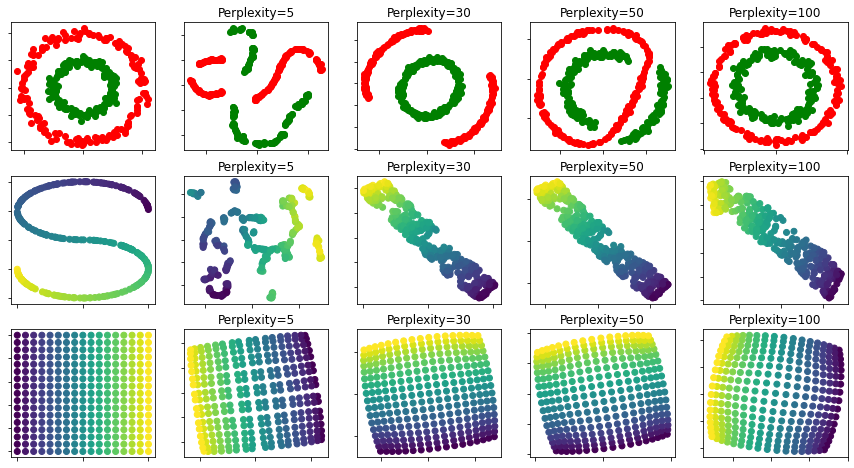

In [58]:
# Author: Narine Kokhlikyan <narine@slice.com>
# License: BSD

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

n_samples = 300
n_components = 2
(fig, subplots) = plt.subplots(3, 5, figsize=(15, 8))
perplexities = [5, 30, 50, 100]

X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)

red = y == 0
green = y == 1

ax = subplots[0][0]
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

for i, perplexity in enumerate(perplexities):
    ax = subplots[0][i + 1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components, init="random", random_state=0, perplexity=perplexity
    )
    Y = tsne.fit_transform(X)
    t1 = time()
    print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[red, 0], Y[red, 1], c="r")
    ax.scatter(Y[green, 0], Y[green, 1], c="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")

# Another example using s-curve
X, color = datasets.make_s_curve(n_samples, random_state=0)

ax = subplots[1][0]
ax.scatter(X[:, 0], X[:, 2], c=color)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[1][i + 1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components, init="random", random_state=0, perplexity=perplexity
    )
    Y = tsne.fit_transform(X)
    t1 = time()
    print("S-curve, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")


# Another example using a 2D uniform grid
x = np.linspace(0, 1, int(np.sqrt(n_samples)))
xx, yy = np.meshgrid(x, x)
X = np.hstack(
    [
        xx.ravel().reshape(-1, 1),
        yy.ravel().reshape(-1, 1),
    ]
)
color = xx.ravel()
ax = subplots[2][0]
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[2][i + 1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components, init="random", random_state=0, perplexity=perplexity
    )
    Y = tsne.fit_transform(X)
    t1 = time()
    print("uniform grid, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")


plt.show()